# Deep Generative Autoencoder Model
**Generative models** are able to learn to represent a certain distribution of data, such as images, and then generate novel random samples indistinguishable from the original examples. Currently, the most common generative models are Generative Adversarial Networks (GAN).

On the other hand, **autoencoder models** can learn to encode new images into a low-dimensional (compressed) representation, which we refer to as the latent (or unobserved) code. This representation can be used to manipulate the images in semantically meaningful ways, such as changing the shape of the nose or rotating the azimuth of the face.

Recently, Balanced PIONEER networks (Progressively Growing Generative Autoencoders) [1] were introduced to combine the best of both worlds. They can both encode new input images for image editing purposes and generate completely novel random images.

For this exercise, we will be using a pre-trained PIONEER model on images with 256x256 resolution, trained with the CelebA-HQ dataset which contains 30,000 images of celebrities, using the codebase [2].

[1] Heljakka, A., Solin, A., and Kannala, J. Towards Photographic Image Manipulation with Balanced Growing of Generative Autoencoders. In Winter Conference on Applications of Computer Vision (WACV), 2020.

[2] https://github.com/AaltoVision/balanced-pioneer

## Task 1: Load the model

Take a moment to make sure you are familiar with the concepts of autoencoders, generative models, and the use of a pre-trained machine learning model. Then run the following code as-is.

In Jupyter, the model works slower than it should. Please take a moment to consider the reason:
In regular neural networks and deep learning setup, we would use a GPU to load and run the model. It would load and operate up 10-100x faster. In this environment, we use the CPU. Make sure you understand, on a high level, why GPU is so much faster for these tasks. You can Google the answer. For your own work, you can use any GPU in principle, e.g. gaming PCs. NVIDIA GPUs tend to have the best compatibility at the moment.

**To run a cell of code, click inside the cell, and then click Run in the menu bar**.

If you run out of memory or encounter "data errors" or similar during the running of this exercise, please restart the kernel (select **Kernel / Restart** in the menu bar), re-run cells 1-3, and then continue from the cell that you were working with!

### Setting Up - Utility Code

In [ ]:
import torch
import sys
sys.argv = ['no']

import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from pioneer import utils
from pioneer import config
from pioneer import train
from pioneer import data
from pioneer import evaluate

In [ ]:
def test_session_setup(dataset_name, model_path, test_images_path, reso, load_checkpoint = -1):
    """load_checkpoint = The checkpoint to start from. -1 = load the newest. 0 = start from scratch.
    """
    global args
    args = config.get_config()
    args.data = dataset_name
    args.save_dir = model_path
    args.start_iteration = load_checkpoint
    args.test_path = test_images_path
    args.testonly = True
    args.disable_cuda = True
    args.max_phase = int(np.log2(reso/4))
    args.e_last_relu = True
    args.upsampling = 'bilinear0' #Smoothen the last layer
    args.no_TB = True
    
    train.setup()
        
    session = train.Session()
    session.create()
    test_data_loader = data.get_loader(args.data, args.test_path)
    
    #evaluate.Utils.reconstruction_dryrun(session.g_running, session.encoder, test_data_loader, session=session)
    
    return session, test_data_loader

def get_data_iterator(session, loader, nr_of_images = 8, resolution = 64):
    return data.Utils.sample_data2(loader, min(nr_of_images, 16), resolution, session)

def encode(session, img):
    return session.encoder(img, session.phase, 1.0, False)

def decode(session, z):
    return session.generator(z, None, session.phase, 1.0)

def decode_running(session, z):
    return session.g_running(z, None, session.phase, 1.0)

%matplotlib inline
def show(img):
    npimg = img.numpy()
    fig = plt.figure(figsize=(15,27))
    plt.imshow(np.transpose(npimg / max(npimg.max(), -npimg.min()), (1,2,0)) / 2 + 0.5, interpolation='nearest')
    
def show_grid(imgs1):
    grid = (make_grid(imgs1[:], padding=5, nrow=5))
    show(grid)

def show_pairs(imgs1, imgs2):
    t = torch.FloatTensor(imgs1.size(0) * 2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::2] = imgs1[:]
    t[1::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2] , padding=5, nrow=2)) #/ 2 + 0.5

    fig = plt.figure(figsize=(10,10))
    show(grid)
    
    return grid

def show_triple(imgs1, imgs2, imgs3):
    t = torch.FloatTensor(imgs1.size(0) * 3, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::3] = imgs1[:]
    t[1::3] = imgs2[:]
    t[2::3] = imgs3[:]

    grid = (make_grid(t[:imgs1.size(0)*3] , padding=5, nrow=3))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid

def show_5(imgs1, imgs2, imgs3, imgs4, imgs5):
    t = torch.FloatTensor(imgs1.size(0) * 5, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::5] = imgs1[:]
    t[1::5] = imgs2[:]
    t[2::5] = imgs3[:]
    t[3::5] = imgs4[:]
    t[4::5] = imgs5[:]

    grid = (make_grid(t[:imgs1.size(0)*5] , padding=5, nrow=5))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid

def reconstruct(session, data_iterator):
    source_images, _ = next(data_iterator)
    with torch.no_grad():
        z = encode(session, source_images)
        dest_images = decode_running(session, z)
        show_pairs(source_images, dest_images)
        
def random_faces(session, random_id, num_imgs):
    import random
    random.seed(random_id)
    torch.manual_seed(random_id)
    torch.cuda.manual_seed_all(random_id)   
    
    from torch.autograd import Variable
    with torch.no_grad():
        myz = Variable(torch.randn(num_imgs, 512))#.cuda()
        myz = utils.normalize(myz)
        myz, input_class = utils.split_labels_out_of_latent(myz)
    
        new_imgs = session.g_running(
            myz,
            input_class,
            session.phase,
            1.0).detach().data.cpu()
    return new_imgs

def show_feat(session, it, feat_delta, alphas = [0.33, 0.66, 1.0]):
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        mo_dest_images = decode_running(session, z)
        z2 = z + alphas[0] * feat_delta
        force_feat_images1 = decode_running(session, z2)
        z3 = z + alphas[1] * feat_delta
        force_feat_images2 = decode_running(session, z3)
        z4 = z + alphas[2] * feat_delta
        force_feat_images3 = decode_running(session, z4)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)

## Load the pre-trained Pioneer model

This may take a few moments - wait for the star [*] to disappear on the left of the cell before continuing.

Note: You may see some deprecation warnings when running the below code. They are harmless.

In [ ]:
session, test_data_loader = test_session_setup(
            dataset_name = 'celebaHQ',
            model_path = '/coursedata/celebaHQ256',
            test_images_path = 'pioneer/test_256_in',
            reso = 256,
            load_checkpoint = 25480000
    )

## Task 2: Generate random faces from the model with your student ID

A proper generative model can generate a completely fabricated sample based on a random (noise) input.
In this case, your student ID can serve as the *random seed* for the noise input. The input itself is a 512-dimensional random vector.
Often these vectors are generated from the Gaussian (aka "normal") distribution, due to their nice theoretical properties. Try generating some random faces below. Note: The images are 128x128, so if they look pixelated, please pay attention to your screen resolution, since your browser may stretch them.

Sometimes, the images will look so realistic that you might think the model is cheating somehow. We will soon show a way to ensure that this is not the case. Sometimes, though, the images will be completely broken in various but often interesting ways. You can experiment with replacing the student_id with any integer and see what happens.

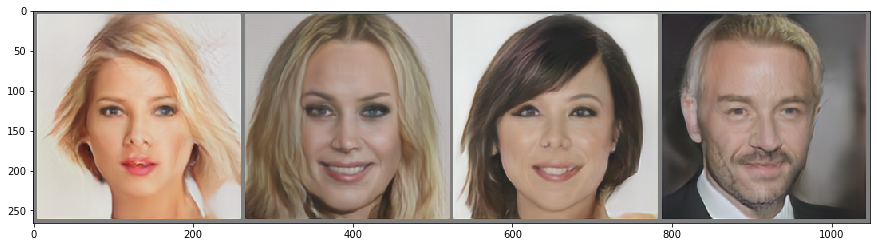

In [ ]:
student_id = 887799 # <= Insert your student ID here (numbers only)
imgs = random_faces(session, student_id, 4)
show_grid(imgs)

## Task 3: Reconstruct a face image
Autoencoders have the capability to encode an input sample (here, a face) into a very compact internal representation called a 'latent code'.
This is similar to compressing an image very tightly.
The latent code can then be decoded back into an image, which we would like to resemble the original image as much as possible.
Take a moment to consider why we do this. What would be the benefit of having the latent code? What could we do with it?
Below, you load in some images from the test dataset and ask the model to encode them into latent space, and then decode back to the image space.
The images on the left are originals and the ones on the right are reconstructions.

In [ ]:
it = get_data_iterator(session, test_data_loader, 1, 256)

<Figure size 720x720 with 0 Axes>

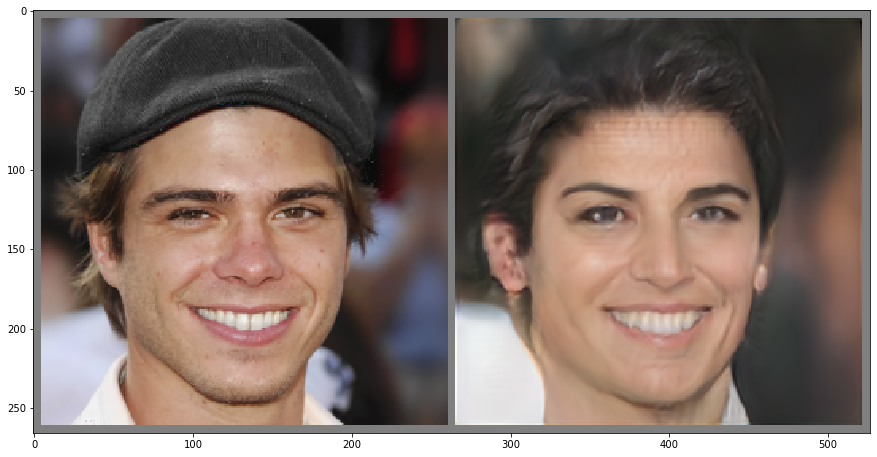

In [ ]:
reconstruct(session,it)

## Task 4: Interpolate between two faces
Consider taking two images as input. The autoencoder creates a latent code for both. Now, these codes are just 512-dimensional vectors (sequences of numbers). What happens if we change them slightly? What happens if we take the vector that is exactly between them?
Try it out below! First, we encode the images into the latent code 'z'.

In [ ]:
it = get_data_iterator(session, test_data_loader, 2, 256)

source_images, _ = next(it)
with torch.no_grad():
    z = encode(session, source_images)
np.shape(z)

torch.Size([2, 512])

Next, we take the latent codes of the two reconstructed images, and find out the vector that is exactly in the middle of them:

In [ ]:
z_mid = (torch.FloatTensor(3, z[0].size(0)))

z_mid[0] = z[0]
z_mid[2] = z[1]
z_mid[1] = z[0] + (z[1] - z[0])/2

# To conserve memory in Jupyter, we will decode images 1-by-1. Normally we would do them in a single batch.
imgs = (torch.FloatTensor(3, 3,256,256))

for i in range(3):
    with torch.no_grad():
        imgs[i,:,:,:] = decode_running(session, z_mid[i].unsqueeze(0))

In [ ]:
imgs2 = (torch.FloatTensor(5, 3,256,256))
imgs2[1:4,:,:,:] = imgs
imgs2[0,:,:,:] = source_images[0]
imgs2[4,:,:,:] = source_images[1]

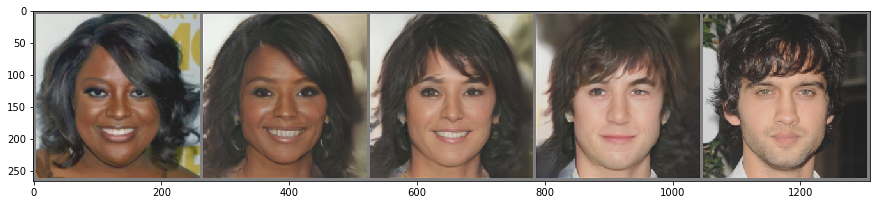

In [ ]:
show_grid(imgs2)

Hold on. Why do we need to do this? We could just take the average between the pixels of the two images, right?
Yes, we can. We try this below. But depending on which samples you see, it often fails. Can you explain why?

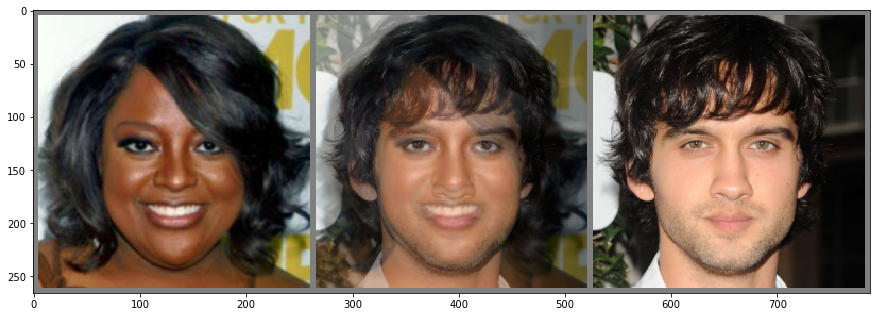

In [ ]:
imgs3 = (torch.FloatTensor(3, 3,256,256))
imgs3[0,:,:,:] = source_images[0]
imgs3[1,:,:,:] = (source_images[0] + source_images[1]) / 2
imgs3[2,:,:,:] = source_images[1]
show_grid(imgs3)

## Task 5: Modify specific image attributes in latent space
We can do much more by latent representation manipulation.
For instance, if we have found the direction in the latent space that corresponds to smiling, we can make a new person smile by adding the smile vector to his/her latent code. Let's try it out!

If you get an error "DataLoader worker ... is killed by signal: Killed." or similar errors, please do the following:
1. Select Kernel / Restart in the menu bar
2. Re-run only cells 1-3
3. Continue directly from here

In [ ]:
smile_delta = torch.load('pioneer/attrib/smile_delta',  map_location=torch.device('cpu'))

<Figure size 1440x1440 with 0 Axes>

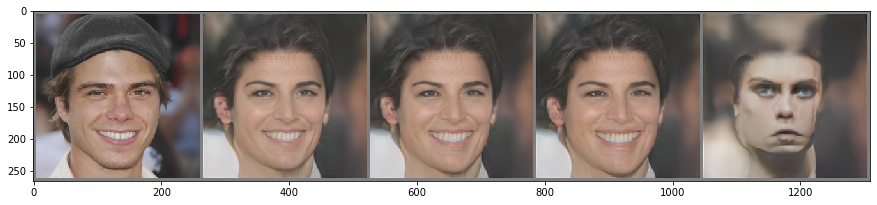

In [ ]:
it = get_data_iterator(session, test_data_loader, 1, 256)

show_feat(session, it, smile_delta, alphas = [0.33, 0.66, -4])

The different values of alpha modify the smile vector. That is, if alpha=0, then the smile will not change.
Find the best alpha values for some input image.
What happens if you use negative values of alpha? For what purpose could you use the negative values?

How would you create the smile_delta vector? It is easier than one might think!

## OPTIONAL Task 6

**These optional tasks are for students already familiar with coding in Python, and are not graded.**

Now you may have an idea of why the latent codes are so useful. We can modify images on a more abstract level by modifying the code. But instead of just taking the middle point between two faces, we can actually take any points between them, and decode them back to image space, as long as they are strictly along the vector that connects the two codes.

In task #4 we just took the middle point between the two vectors.
Try writing the code that produces 5 intermediate points between the two vectors, with evenly spaced intervals (e.g. in 1-dimension, if your latent codes are 2 and 5, you would generate the intermediate points 2.5, 3.0, 3.5, 4, and 4.5).
Then, decode these back to the image space.
You should see a smooth transition from one image to the next.


## OPTIONAL Task 7
Find your own face images at 128x128 resolution and align the images as exactly as possible to resemble the test images given here. (The resolution must be exact and their eye positions must align as well as possible.)
Upload the aligned images to the Jupyter environment.
Run the reconstructions and interpolations for your own images.
Does the reconstruction look good? If not, consider why this could be the case. Note that the model has been trained with a dataset that has many more female than male faces, so it often reconstructs male faces as female.